In [0]:
from google.colab import drive

In [0]:
!pip install --upgrade category_encoders
!pip install catboost

In [0]:
drive.mount("/content/gdrive")

**Importing the required libraries and reading data into data frames.**

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from random import sample
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer 
from category_encoders import TargetEncoder
from category_encoders import CatBoostEncoder
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score 
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, r2_score
from sklearn.impute import SimpleImputer
from google.colab import files
from sklearn.model_selection import KFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.tree import DecisionTreeRegressor

In [0]:
df = pd.read_csv('/content/gdrive/My Drive/vehicles.csv')
dff= df.copy()

# **Task 1**

In [0]:
#seeing if there are any duplicates in the data by seeing if there are any duplicate IDs.
print("Are there any duplicate reocrds:",df['id'].duplicated().any())

#dropping off un-necessary columns like the URL, id, region URL, vin, image_url, description, county
columns = ['id', 'url','region_url','image_url','vin','description','county']
df.drop(columns, inplace=True, axis=1)

#Removing a row with the year as 0
df=df[df['year']!=0]

#Treating 0 values and 1 values in the target column (price) as NAs and removing them
df=df[df['price']!=0]
df=df[df['price']!=1]

Are there any duplicate reocrds: False


As Pre-processing of the data we are checking if there are any duplicates in the data by checking if there are any duplicates in the id column. There are no duplicate rows in the data. We are also dropping some un-necessary columns like id, url, region_url, image_url, vin, description, county. The county column doesn't have any data. We can extract features from the description column but we are not using it. Region URL is not useful for prediction. id, url, vin, image_url are unique identifiers for the rows that will leak information, it is because the values of these won't repeat in the test set and once occured the model might learn the one to one mapping between these and the price column. The plots to show how each value of these variables have only one price amount associated with them are shown as we progress.

There were some zero values in the column year and they were removed, and the price values of 0 and 1 were removed.

In [0]:
# See if there are missing values in each column
print(df.isnull().sum(axis = 0))

region               0
price                0
year              1511
manufacturer     20674
model             7003
condition       202308
cylinders       179303
fuel              3769
odometer         81840
title_status      2899
transmission      3232
drive           130899
size            309153
type            129552
paint_color     146741
state                0
lat               5412
long              5412
dtype: int64


In [0]:
#finding the categorical and continuous variables
print("all the variables are:")
print(list(df))

cat_variables= list(df.select_dtypes(object).columns)
cont_variables= list(df.columns[df.dtypes !=object])
print("\n\n\n Categorical Variables",cat_variables)
print("\n\n\n Continuous Variables",cont_variables)

#Removing price as it is the target variable
cont_variables.remove('price')

all the variables are:
['region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long']



 Categorical Variables ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']



 Continuous Variables ['price', 'year', 'odometer', 'lat', 'long']


In [0]:
#Checking if the model column is leaking any information

#We are grouping by models, then we are seeing if all the prices listed corresponding to a model are same
#If true for all models then it would mean that the model column is leaking data
g=pd.DataFrame(df.groupby('model').price.nunique().eq(1))

#We are seeing if there are only True values in the grouping
set(g['price'])

{False, True}


If there were only True for all the models, then the model column might be leaking information but since there are false also it is not entirely leaking information. Now some car models in the column might be leaking info not all of them, so we can't remove the entire column.

***Seeing if information is leaked by the continuous columns***

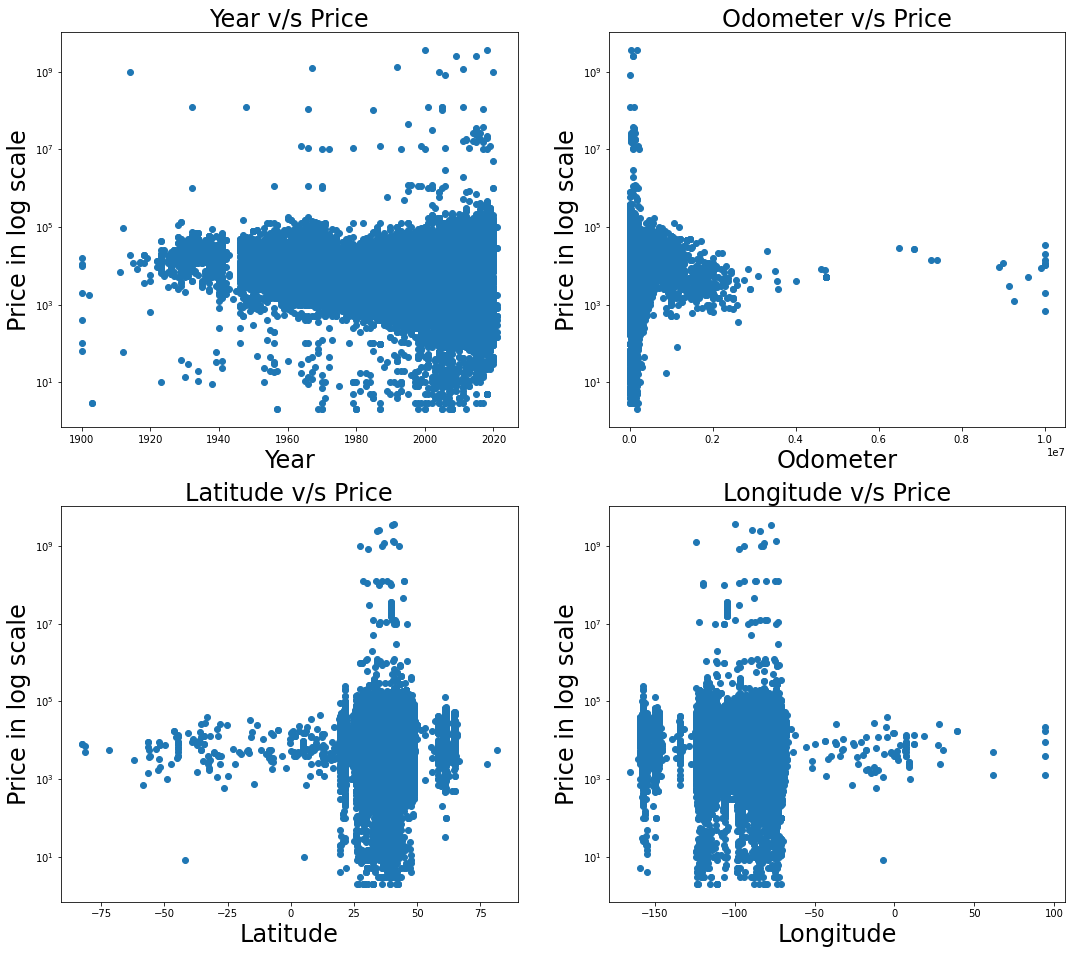

In [0]:
#Scatter Plot of continuous variables v/s the target variable to see if there is any data leak

fig, axes = plt.subplots(2, 2, figsize=(18,16))
axes[0, 0].scatter(df['year'],df['price'])
axes[0,0].set_title("Year v/s Price",fontsize=24)
axes[0,0].set_xlabel("Year",fontsize=24)
axes[0,0].set_ylabel("Price in log scale",fontsize=24)
axes[0,0].set_yscale('log')

#We are letting the 0 values in the odometer column be, as there are some new cars in the dataset
#Removing the outlier from odometer to make the plot look better
df1=df[df['odometer']<60000000]
axes[0, 1].scatter(df1['odometer'],df1['price'])
axes[0,1].set_title("Odometer v/s Price",fontsize=24)
axes[0,1].set_xlabel("Odometer",fontsize=24)
axes[0,1].set_ylabel("Price in log scale",fontsize=24)
axes[0,1].set_yscale('log')

axes[1, 0].scatter(df['lat'],df['price'])
axes[1,0].set_title("Latitude v/s Price",fontsize=24)
axes[1,0].set_xlabel("Latitude",fontsize=24)
axes[1,0].set_ylabel("Price in log scale",fontsize=24)
axes[1,0].set_yscale('log')


axes[1, 1].scatter(df['long'],df['price'])
axes[1,1].set_title("Longitude v/s Price",fontsize=24)
axes[1,1].set_xlabel("Longitude",fontsize=24)
axes[1,1].set_ylabel("Price in log scale",fontsize=24)
axes[1,1].set_yscale('log')

From the Visualization we can see that no continuous variable is leaking any information about the target variable.

We can also see that most of the data points are concentrated in the latitude range (25 to 50) and the longitude range (-125 to -75).

Unique identifiers for rows also leak information, that is because there is a chance that a complex model might learn the price 
of the vehicle from its unique identifiers. These unique identifiers don't also appear in the test set, so they have to be removed. We removed the url, id, vin and image_url columns when we were selecting only the useful columns.

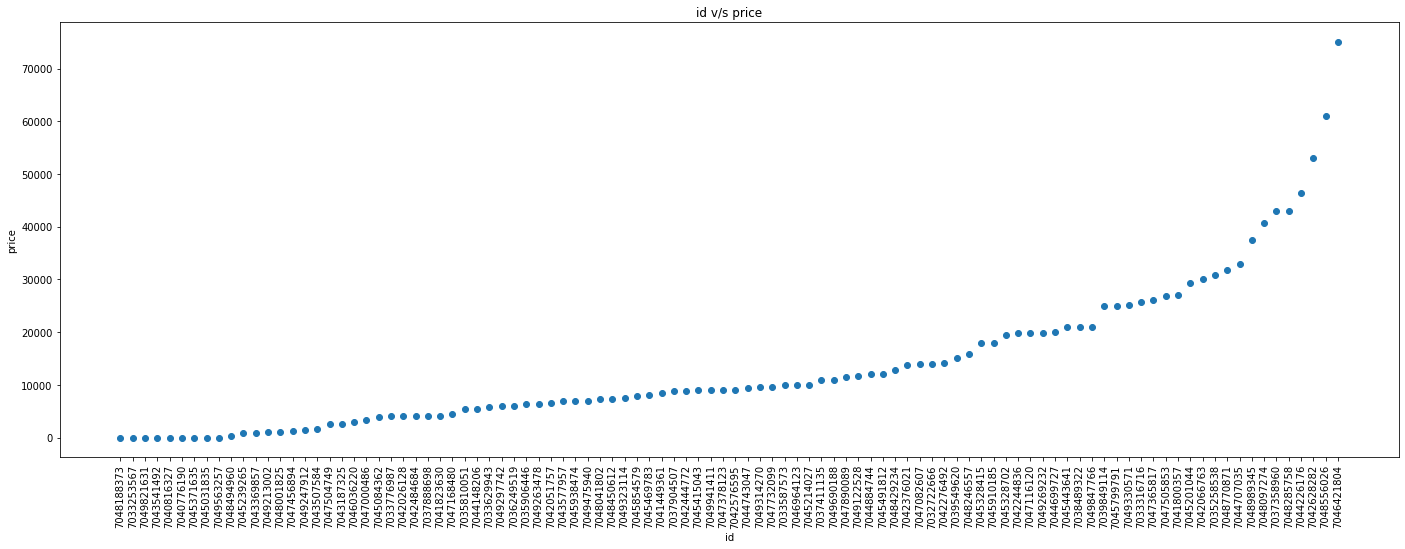

In [0]:
#Plot based proof that the unique identifiers leak information

#For unique identifier 'id' column
dfs = dff.sample(n=100)

dfs1 = dfs.copy()
#Finding the order for lower to higher price based on the id
f1=list(dfs.groupby('id',as_index=False)['price'].mean().sort_values(by=['price'])['id'])
#Note: In the above line we are using the mean function to just convert the group by object to data frame, since id is a 
#unique identifier, grouping by it will have only one row per group and usage of mean() will not have any effect

dfs1['id'] = [f1.index(x) for x in dfs1['id']]

plt.figure(figsize=(24,8))
plt.xticks(range(len(f1)), f1 , rotation=90)
plt.scatter(dfs1['id'],dfs1['price'])
plt.title("id v/s price")
plt.xlabel("id")
plt.ylabel("price");


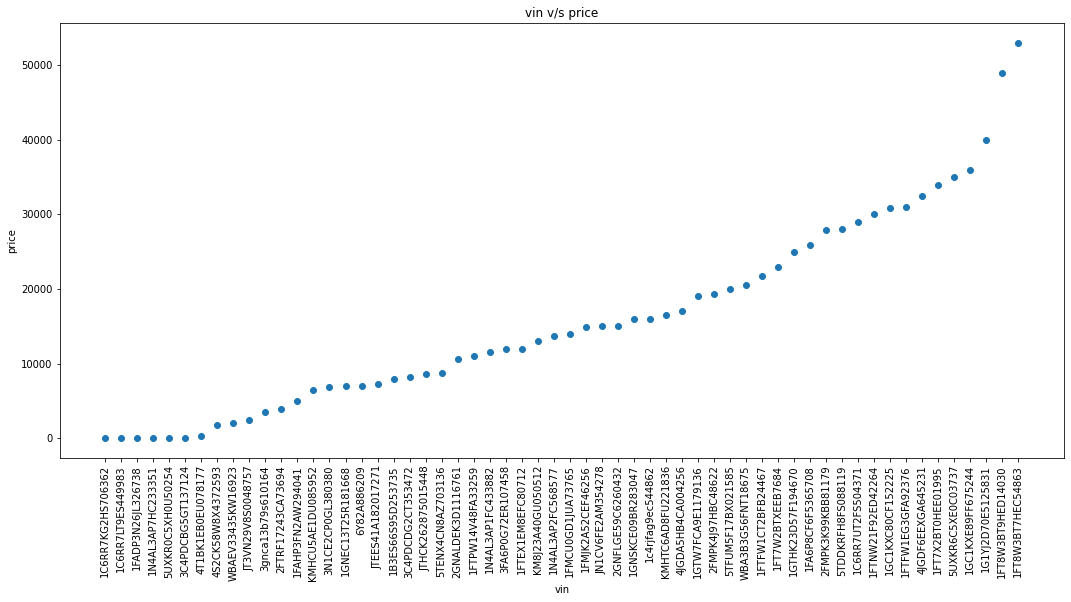

In [0]:
#For unique identifier 'vin' column
dfs2 = dfs.copy()

#Removing NA values for plotting this
dfs2= dfs2[~(dfs2['vin'].isnull())]

#Finding the order for lower to higher price based on the vin
f1=list(dfs.groupby('vin',as_index=False)['price'].mean().sort_values(by=['price'])['vin'])

dfs2['vin'] = [f1.index(x) for x in dfs2['vin']]

plt.figure(figsize=(18,8))
plt.xticks(range(len(f1)), f1 , rotation=90)
plt.scatter(dfs2['vin'],dfs2['price'])
plt.title("vin v/s price")
plt.xlabel("vin")
plt.ylabel("price");

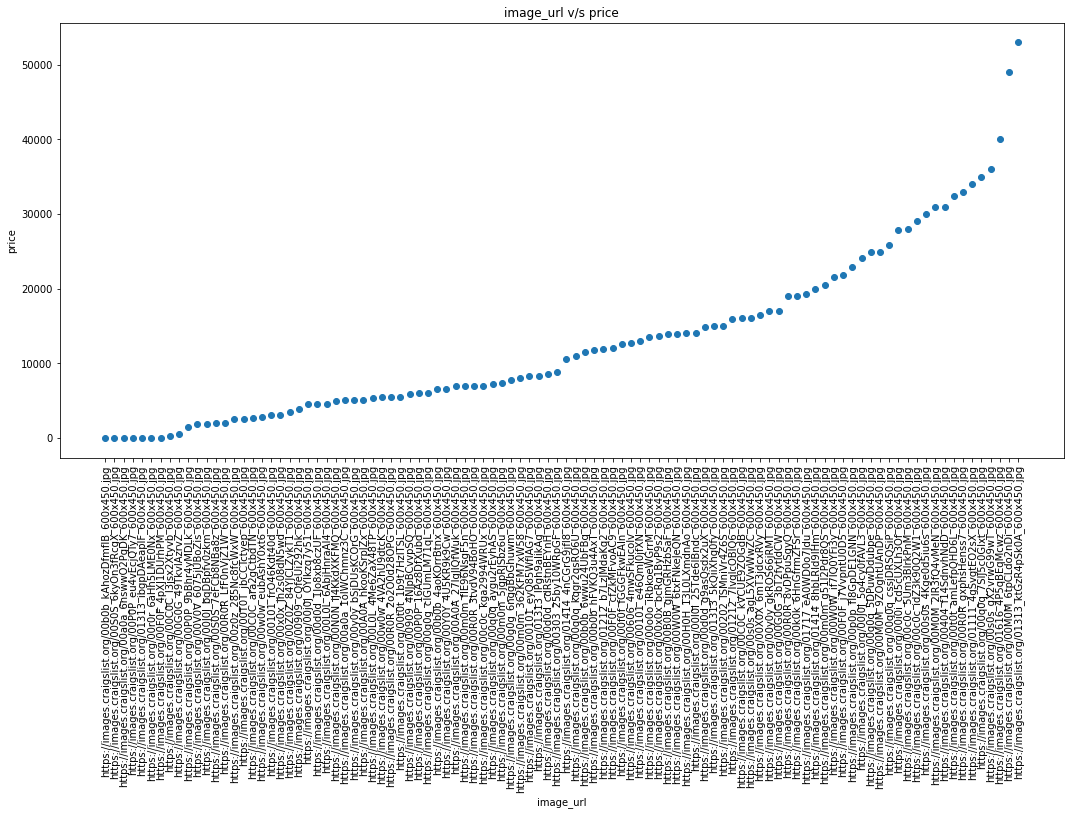

In [0]:
#For unique identifier 'image_url' column
dfs3 = dfs.copy()

#Removing NA values for plotting this
dfs3= dfs3[~(dfs3['image_url'].isnull())]

#Finding the order for lower to higher price based on the vin
f1=list(dfs.groupby('image_url',as_index=False)['price'].mean().sort_values(by=['price'])['image_url'])

dfs3['image_url'] = [f1.index(x) for x in dfs3['image_url']]

plt.figure(figsize=(18,8))
plt.xticks(range(len(f1)), f1 , rotation=90)
plt.scatter(dfs3['image_url'],dfs3['price'])
plt.title("image_url v/s price")
plt.xlabel("image_url")
plt.ylabel("price");

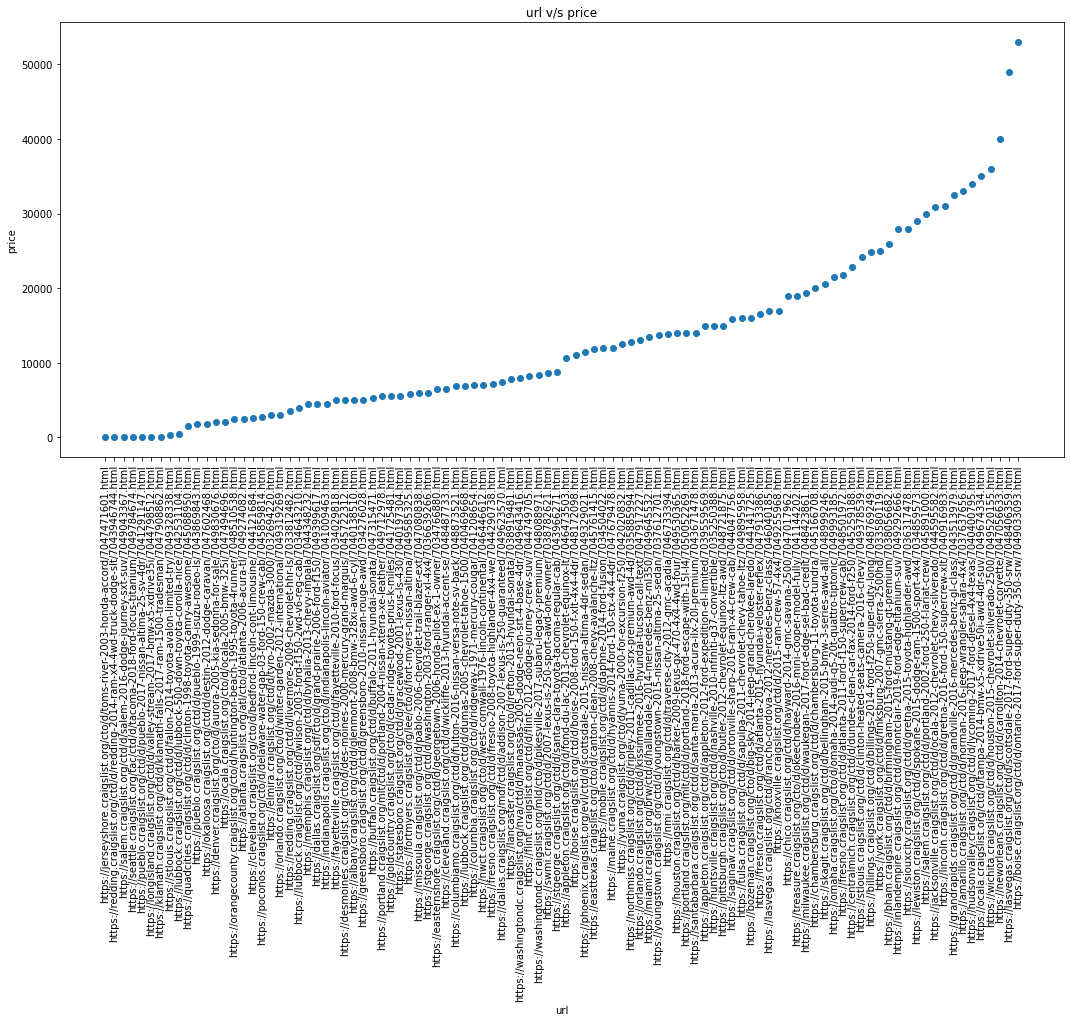

In [0]:
#For unique identifier 'url' column
dfs4 = dfs.copy()

#Removing NA values for plotting this
dfs4 = dfs4[~(dfs4['url'].isnull())]

#Finding the order for lower to higher price based on the vin
f1=list(dfs.groupby('url',as_index=False)['price'].mean().sort_values(by=['price'])['url'])

dfs4['url'] = [f1.index(x) for x in dfs4['url']]

plt.figure(figsize=(18,8))
plt.xticks(range(len(f1)), f1 , rotation=90)
plt.scatter(dfs4['url'],dfs4['price'])
plt.title("url v/s price")
plt.xlabel("url")
plt.ylabel("price");

From each of the plots we saw that each entry (each row) of those unique identifiers had only one price corresponding to it (proving our point that they were the primary keys of the dataset). So from our explanation any unique columns will contribute to leakage of information and hence should be removed.

Note: we ordered the x-axis based on the corresponding price values so that the plots look good.

In [0]:
#Removing the ouliers from the price variable
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

dff1 = df[~((df['price'] < (Q1 - 1.5 * IQR)) |(df['price'] > (Q3 + 1.5 * IQR)))]

#Removing the outliers from the odometer column

Q1 = dff1['odometer'].quantile(0.25)
Q3 = dff1['odometer'].quantile(0.75)
IQR = Q3 - Q1

dff1 = dff1[~((dff1['odometer'] < (Q1 - 1.5 * IQR)) |(dff1['odometer'] > (Q3 + 1.5 * IQR)))]

#subsetting of the data
dff=dff1.sample(frac=0.15, random_state=0)

#splitting the dataset into X and Y (target and the training columns)
y=pd.DataFrame(dff['price'])
X= dff.loc[:, dff.columns != 'price']

We removed the outliers form the odometer and the price columns and sampled the data. We then split it into X and y (target) dataframes. 

# **Task 2**

***Simple Viable Model***

In [0]:
#See no of unique categories in the categorical data to see if you'll encode them or drop them. 
print("Unique no of categories in each of the categorical columns are: \n")
for i in cat_variables:
    print("In the column",i,":",len(set(dff[i])),"\n")


Unique no of categories in each of the categorical columns are: 

In the column region : 401 

In the column manufacturer : 41 

In the column model : 10736 

In the column condition : 7 

In the column cylinders : 9 

In the column fuel : 6 

In the column title_status : 7 

In the column transmission : 4 

In the column drive : 4 

In the column size : 5 

In the column type : 14 

In the column paint_color : 13 

In the column state : 51 



In [0]:
#See the percentage of NA values in each categorical column to see if you should keep it or remove it 

for i in cat_variables:
    print("Percentage of NAs in ",i," is: ",dff[i].isnull().sum()/len(df)*100)

Percentage of NAs in  region  is:  0.0
Percentage of NAs in  manufacturer  is:  0.5880141883805632
Percentage of NAs in  model  is:  0.22617592036533785
Percentage of NAs in  condition  is:  6.221457981396113
Percentage of NAs in  cylinders  is:  5.47661120640119
Percentage of NAs in  fuel  is:  0.09958653227165304
Percentage of NAs in  title_status  is:  0.08684118432365408
Percentage of NAs in  transmission  is:  0.09829039519219554
Percentage of NAs in  drive  is:  4.069654406650047
Percentage of NAs in  size  is:  9.582125405582895
Percentage of NAs in  type  is:  3.9942624331949346
Percentage of NAs in  paint_color  is:  4.569315250780923
Percentage of NAs in  state  is:  0.0


Since this is a simpler version of the model, we will be one hot encoding all the categorical columns, doing this will create a lot of new columns. So for the simpler model we will be dropping the region and model columns. Since we can also see that there are a lot of NA values in the condition, cylinders, size and paint_color columns, we will be dropping them also as of now. We will be imputing the missing values in the rest of the columns.

In [0]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=100)

X_train1 = X_train.copy()
X_test1= X_test.copy()
#removing the aforementioned columns
columns1 = ['condition', 'cylinders','size','paint_color','region', 'model']
X_train1.drop(columns1, inplace=True, axis=1)
X_test1.drop(columns1,inplace=True, axis=1)

#Getting the categorical and the continuous columns of the new dataframe
cat_variables1= list(X_train1.select_dtypes(object).columns)
cont_variables1= list(X_train1.columns[X_train1.dtypes !=object])

cont_preprocessing = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())
cat_preprocessing = make_pipeline(SimpleImputer(strategy='constant',fill_value='NA'),OneHotEncoder(handle_unknown='ignore'))

preprocess = make_column_transformer((cat_preprocessing, cat_variables1), (cont_preprocessing,cont_variables1))

pipe_grid={}
grid = GridSearchCV(make_pipeline(preprocess,LinearRegression(n_jobs=-1)),param_grid=pipe_grid,cv=5,scoring="r2")
grid.fit(X_train1,y_train)

print("Training Score for Simple Viable Model: ",grid.best_score_)
print("Testing Score for Simple Viable Model: ", grid.best_estimator_.score(X_test1, y_test))

Training Score for Simple Viable Model:  0.536889251409745
Testing Score for Simple Viable Model:  0.5308519635166351


We can see that by removing certain features, and one hot encoding the rest of the features we get poor r2 score, so it was not a good idea. We will thus use feature engineering to improve the model performance.

# **Task 3**

Note: We have used polynomial features on all the columns as catboost encoding of the categorical columns makes them numerical, (like how target encoding makes the categorical columns into numeric). Interactions between the categorical columns will also provide some required information.

In [0]:

#Clean the columns like cylinders, we are making them numeric instead of categorical, by removing the categorical parts. This can
#be done as they already follow the intuitive odinal order(like 8 cylinders is expensive than 4 cylinders etc). 

li=[]
for i in X['cylinders']:
    #Only changing the strings, and not altering the NAs of the column
    if isinstance(i,str) and i!='other':
        i1=i.replace('cylinders', '')
        li.append(float(i1))
    
    #If the cylinder value is missing, or specified as other
    else:
        li.append(np.nan)

X['cylinders1']=li

#add cylinders1 to cont column
cont_cols=cont_variables.copy()
cont_cols.append('cylinders1')
cat_cols = cat_variables.copy()
cat_cols.remove('cylinders')

cat_cols_cb = cat_cols.copy()
cat_cols_cb.remove('state')
cont_cols_1=cont_cols.copy()

X1 = X.copy()
X1.drop(['cylinders'], inplace=True, axis=1)

X2=X1[~X1['cylinders1'].isnull()]
y1=y[~X1['cylinders1'].isnull()]

X3= X2.copy()
X3.drop(['state'],axis=1, inplace=True)

cont_preprocessing = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())

cat_preprocessing_cb = make_pipeline(CatBoostEncoder(handle_missing='value',return_df=True),StandardScaler())

#Making a K-means column transformer
class KMeansTransformer:
    
    def __init__(self, k):
        self.k = k

    def fit(self, X):
        km = KMeans(self.k,max_iter=10000,random_state=0).fit(X.loc[:,["lat","long"]])
        self.model_ = km
        return self
    
    def transform(self, X):
        V=X.copy()
        V["loc"]=self.model_.predict(X.loc[:,["lat","long"]])
        V = V.drop(["lat","long"],axis=1)
        return V
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)



#Removing the missing values in latitude and longitude
X4=X3[~(X3['lat'].isnull()|X3['long'].isnull())]
y1=y1[~(X3['lat'].isnull()|X3['long'].isnull())]

X4.drop(['region'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X4, y1,test_size=0.2, random_state=10)

cont_cols1=cont_cols.copy()
cont_cols1.remove('lat')
cont_cols1.remove('long')
cat_cols_cb1=cat_cols_cb.copy()
cat_cols_cb1.append('loc')
cat_cols_cb1.remove('region')

preprocess2 = make_column_transformer((cat_preprocessing_cb, cat_cols_cb1), (cont_preprocessing,cont_cols1))

pipe_grid={}
#Also added Polynomial Features
grid = GridSearchCV(make_pipeline(KMeansTransformer(49),preprocess2,PolynomialFeatures(2),LinearRegression(n_jobs=-1)),param_grid=pipe_grid,cv=5,scoring="r2")
grid.fit(X_train,y_train)

print("Training Score for Model with better pre-processing, Polynomial Features, and geo encoding: ",grid.best_score_)
print("Testing Score for Model with better pre-processing, Polynomial Features, and geo encoding: ", grid.best_estimator_.score(X_test, y_test))

Training Score for Model with better pre-processing, Polynomial Features, and geo encoding:  0.7417013444345626
Testing Score for Model with better pre-processing, Polynomial Features, and geo encoding:  0.7395697224588982


We first used a combinaiton of the Target Encoder and One Hot Encoder it worked better than just the One Hot Encoder. We used Ordinal Encoding for the variables size (order: sub-compact, compact, mid-size, full-size) and condition (order: salvage, fair, good, excellent, like new, new) and Catboost for all the other columns it worked better than Target and One Hot Encoder. Catboost encoder on all the categorical columns worked better than the combination of Catboost Encoder and Ordinal Encoder. Adding the Polynomial Features also improved the performance.

We removed the state and region columns as we fond that they were already represented in the latitude and longitude column. We didn't want to use latitude and longitude as continuous columns and that's why we used K-means based clustering to mke them into one categorical column called 'loc'.


We observed that the K-value (from K means clustering) of 49 was giving the optimal performance for the model.


Note: We used a K means transformer class instead of just fitting K means object on training and using it to transform the test set because, when we are doing cross validation we only send the training dataframe which would be split into training and validation. Thus if we fit the K means clustering object on the entire training set it will leak information during cross validation. This is why we wrote a K means transformer class. 


To see the illustration of how the latitude and longitude columns encode the state data:

Changing the categorical cylinders column into a numerical one and removing the missing values in that column made a lot of difference. We removed missing values because after converting the cylinders column to numeric it will have ordinal encoding(i.e. the data in that numeric column follows an intuitive order ex: 8 > 6 (because a car with 8 cylinder will be more expensive than 6 cylinders given all the other features are same)) doing median imputation on that column gives the rows an order that wasn't previously present in the data. That is why we chose to remove the missing values only for this column instead of imputing them.


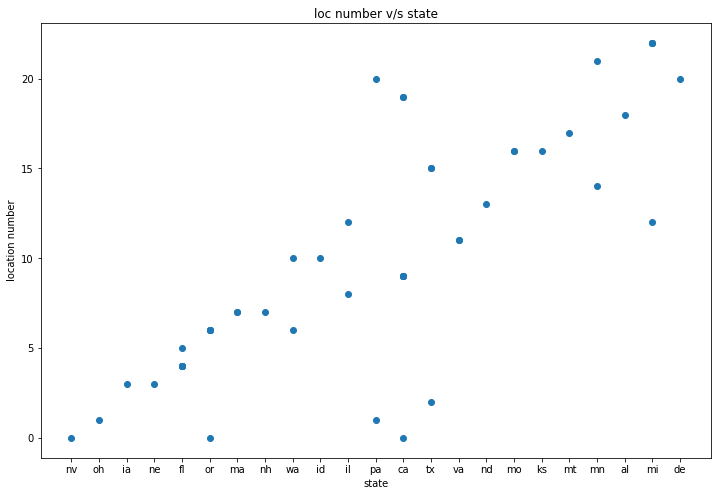

In [0]:
fd=df.sample(n=50,random_state=0)
fd=fd[~(fd['lat'].isnull()|fd['long'].isnull())]
km=KMeansTransformer(k=len(set(fd['state'])))
fd1=km.fit_transform(fd)

#Ordering the x-axis based on the increasing order of the location number
f1=list(fd1.groupby('state',as_index=False)['loc'].mean().sort_values(by=['loc'])['state'])
fd1['state'] = [f1.index(x) for x in fd1['state']]

#Plotting
plt.figure(figsize=(12,8))
plt.xticks(range(len(f1)), f1)
plt.scatter(fd1['state'],fd1['loc'])
plt.title("loc number v/s state")
plt.xlabel("state")
plt.ylabel("location number");

In the above code we used the K-means clustering to encode the latitude and the longitude data. The "k" in K-means represents the no of clusters to be made, thus we intialized k as the no of unique states in the subset of dataframe we are considering. We did this to check our assumption that each cluster we obtained corresponds to one state from the subset. This can be checked by making a scatter plot between the state and the location columns. Ideally if our assumption is true we should see that for each value of x (state), there should only be one corresponding value of y(location). To make the visualization clear, we ordered the x-axis based on the increasig order of the location number.

We can see from the above plot that most of the unique categorical variables (state) more or less had one corresponding location number which was obtained by clustering and encoding the latitude and longitude columns. So we can conclude that most of the data from the state column is encoded by the latitude and longitude columns, thus it is justified to drop the state column. Similar reasoning applies for the region column.

Note: K-means encoded the locations in numbers (i.e. from 0 to 50 if there are 50 states). There is no ordering in the location number (i.e. cluster with a number 2 is in no way higher than the cluster with a number 1), it was just encoded as a number for the sake of convenience. 

# **Task 4**

***Grid Searching for Lasso and Ridge***

In [0]:
pipe = Pipeline([("KMeans",KMeansTransformer(49)),("pre",preprocess2),("poly",PolynomialFeatures(2)),("regressor",Ridge())])

pipe_grid={'regressor__alpha': np.logspace(-4, 4, 9)}

grid1 = GridSearchCV(pipe,param_grid=pipe_grid,cv=5,n_jobs=-1,scoring="r2")
grid1.fit(X_train,y_train)

print("Best alpha value is:", grid1.best_params_)
print("Training Score for Ridge Regression with best alpha: ",grid1.best_score_)
print("Testing Score for Ridge Regression with best alpha: ", grid1.best_estimator_.score(X_test, y_test))

Best alpha value is: {'regressor__alpha': 0.0001}
Training Score for Ridge Regression with best alpha:  0.7417013443977807
Testing Score for Ridge Regression with best alpha:  0.7395697223602455


We can see that the alpha value is really low, and it is as good as having no regularization at all. This is why the scores are same as the ones we obtained from 3 (as they both are linear models the pre-processing we used is the same). Now let us try with Lasso Regression.

In [0]:
pipe = Pipeline([("KMeans",KMeansTransformer(49)),("pre",preprocess2),("poly",PolynomialFeatures(2)),("regressor",Lasso())])

pipe_grid={'regressor__alpha': np.logspace(-4, 4, 9)}

grid1 = GridSearchCV(pipe,param_grid=pipe_grid,cv=5,n_jobs=-1,scoring="r2")
grid1.fit(X_train,y_train)

print("Best alpha value is:", grid1.best_params_)
print("Training Score for Lasso Regression with best alpha: ",grid1.best_score_)
print("Testing Score for Lasso Regression with best alpha: ", grid1.best_estimator_.score(X_test, y_test))

Best alpha value is: {'regressor__alpha': 1.0}
Training Score for Lasso Regression with best alpha:  0.741701995801345
Testing Score for Lasso Regression with best alpha:  0.7395485817811422


For this the training accuracy is very slightly lower than ridge regression and the testing accuracy is slightly higher than ridge, this could mean that this model is slightly better generalized than ridge regression. The best value of alpha here is 1.

***Fine-tuning GradientBoostingRegressor***

In [0]:
onehot_pre = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))
numerical_pre = make_pipeline(SimpleImputer(strategy="median"))
comb_pre = make_column_transformer((numerical_pre,["odometer"]),remainder=onehot_pre)

pipe = Pipeline([("KMeans",KMeansTransformer(49)),("pre",comb_pre),("regressor1",TransformedTargetRegressor(regressor=GradientBoostingRegressor(min_samples_split=50,max_depth=10),func=lambda x:np.log(1+x), inverse_func=lambda x:np.exp(x)-1))])

pipe_grid={"pre":[comb_pre],"regressor1__regressor__min_samples_split":[10],"regressor1__regressor__n_estimators":[100,200,300],"regressor1__regressor__max_depth":[5,10],"regressor1__regressor__min_samples_leaf":[7]}
grid3 = GridSearchCV(pipe,param_grid=pipe_grid,cv=5,n_jobs=-1,scoring="r2")
grid3.fit(X_train,y_train)

print("Best estimators are, max depth: ", grid3.best_params_['regressor1__regressor__max_depth'], "no of estimators: ", grid3.best_params_['regressor1__regressor__n_estimators'])
print("Training Score for Gradient Boosting Regressor with best parameters: ",grid3.best_score_)
print("Testing Score for Gradient Boosting Regressor with best parameters: ", grid3.best_estimator_.score(X_test, y_test))

Best estimators are, max depth:  10 no of estimators:  300
Training Score for Gradient Boosting Regressor with best parameters:  0.7877769936581622
Testing Score for Gradient Boosting Regressor with best parameters:  0.7865597490369602


***CatBoosting, We are using this as most of the variables are categorical***

In [0]:
summ = X_train.describe(include="all")
X_train1 = X_train.copy()
X_test1 = X_test.copy()
y_train1=y_train.copy()
y_test1=y_test.copy()
for col in X_train1.columns:
    if(X_train1[col].dtype=="object"):
        X_train1[col] = X_train1[col].fillna(summ[col]["top"])
        X_test1[col] = X_test1[col].fillna(summ[col]["top"])
    else:
        X_train1[col] = X_train1[col].fillna(summ[col]["50%"])
        X_test1[col] = X_test1[col].fillna(summ[col]["50%"])
X_train1["year"]=X_train1["year"].astype("str")
X_test1["year"]=X_test1["year"].astype("str")
categorical_features_indices = np.where(X_train1.dtypes != np.float)[0]
#Train, Validation Split
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train1, y_train1,test_size=0.2, random_state=10)

train_pool = Pool(X_train2,y_train2,cat_features=categorical_features_indices)
test_pool = Pool(X_validation,y_validation,cat_features=categorical_features_indices)
model2 = CatBoostRegressor(iterations=2000,eval_metric="R2",random_seed=2345,l2_leaf_reg=10, verbose=False)
model2.fit(train_pool,eval_set=test_pool,use_best_model=True) 
print("Training Score for CatBoosting model: ",model2.get_best_score()['learn']['R2'])
print("Validation Score for CatBoosting model: ",model2.get_best_score()['validation']['R2'])
y_pred=model2.predict(X_test1)
print("Testing Score for CatBoosting model: ",r2_score(y_test1, y_pred))


Training Score for CatBoosting model:  0.8483466393138042
Validation Score for CatBoosting model:  0.824600692186485
Testing Score for CatBoosting model:  0.8282611997483151


We can see that CatBoosting is our best model. Its performance is slightly better than tuned gradient boosting model. 

# **Task 5**

Plotting permutation importance for each feature using the catboost model

In [0]:
PI_CAT = permutation_importance(model2,X_test1,y_test1,scoring="r2",n_repeats=10,n_jobs=-1,random_state=1234)

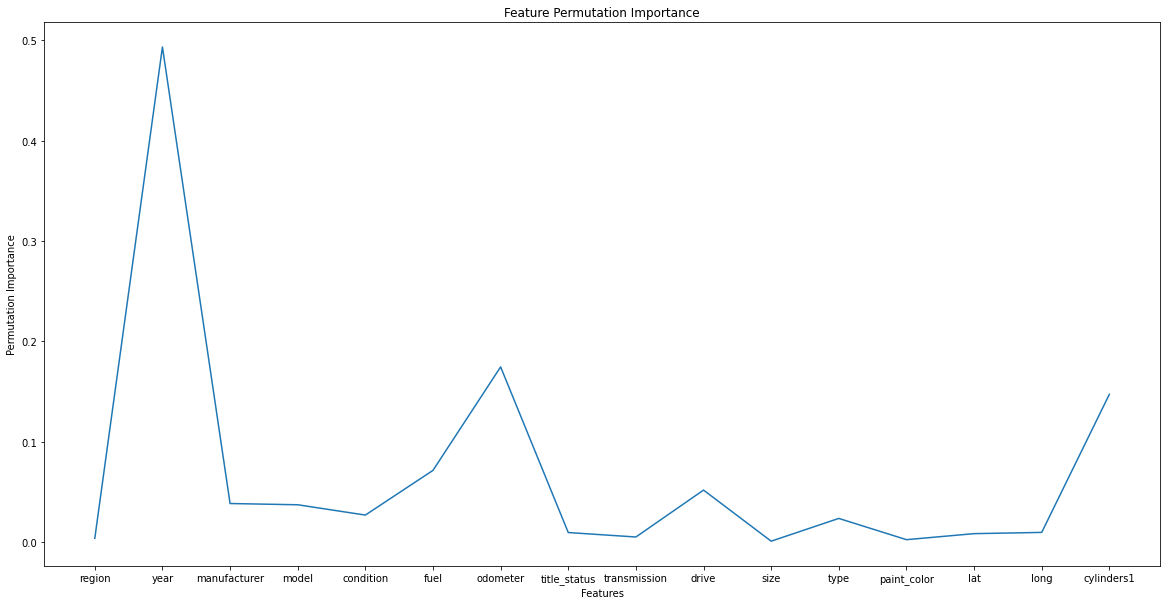

In [0]:
plt.figure(figsize=(20,10))
plt.plot(PI_CAT.importances_mean)
plt.xlabel("Features")
plt.ylabel("Permutation Importance")
plt.title("Feature Permutation Importance")
ticks = plt.xticks(range(len(model2.feature_names_)),model2.feature_names_)

Since we have categorical features there is no simple way to find out the correlation/collinearity between two of the features which might cause one of the features to have a low permutation importance.

The "year","odometer","cylinders" seem to be the most important features.
Dropping the most important features to see if some other features that are colinear with the important features are also important

In [0]:
X_train1_noimp = X_train1.drop(["year","odometer","cylinders1"],axis=1)
X_test1_noimp = X_test1.drop(["year","odometer","cylinders1"],axis=1)
categorical_features_indices = np.where(X_train1_noimp.dtypes != np.float)[0]
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train1_noimp, y_train1,test_size=0.2, random_state=10)
train_pool = Pool(X_train2,y_train2,cat_features=categorical_features_indices)
test_pool = Pool(X_validation,y_validation,cat_features=categorical_features_indices)
model2 = CatBoostRegressor(iterations=2000,eval_metric="R2",random_seed=2345,l2_leaf_reg=10, verbose=False)
model2.fit(train_pool,eval_set=test_pool,use_best_model=True) 

In [0]:
PI_CAT = permutation_importance(model2,X_test1_noimp,y_test1,scoring="r2",n_repeats=10,n_jobs=-1,random_state=1234)

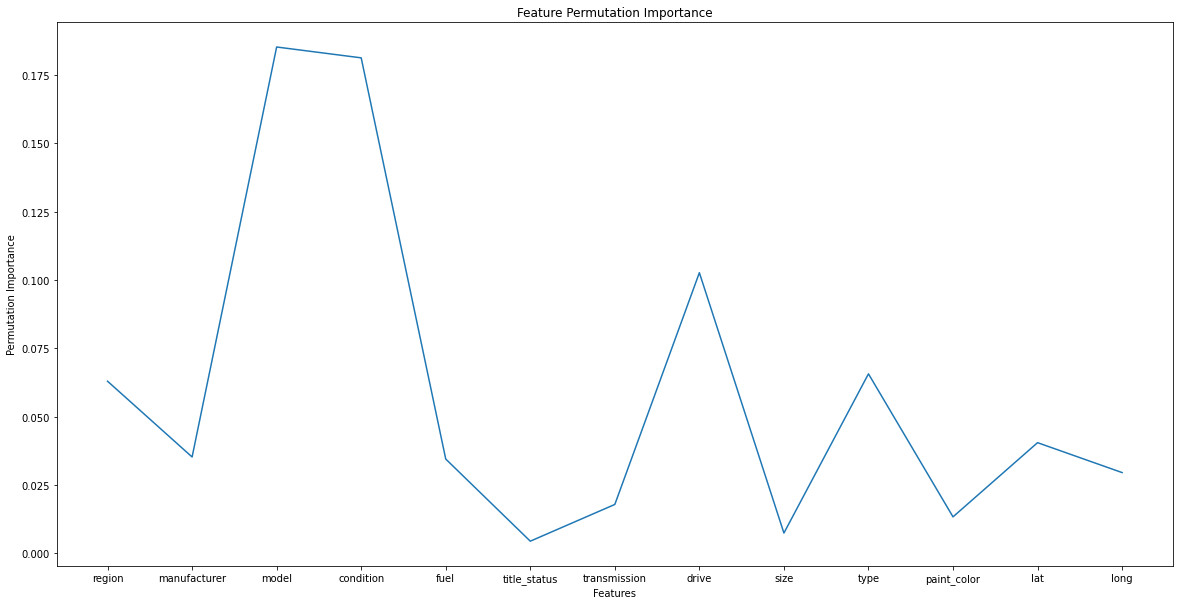

In [0]:
plt.figure(figsize=(20,10))
plt.plot(PI_CAT.importances_mean)
plt.xlabel("Features")
plt.ylabel("Permutation Importance")
plt.title("Feature Permutation Importance")
ticks = plt.xticks(range(len(model2.feature_names_)),model2.feature_names_)

The "model","condition","drive" columns also seem to considerable contribute to the model and might have just been hidden as they were highly correlated to some of the most important features.

We will try to learn the catboost model using only the top 8 most important features to see if we have nearly the same accuracy as the model with all the features

In [0]:
X_train1_noimp = X_train1.drop(["title_status","transmission","size","paint_color","lat","long","manufacturer","fuel"],axis=1)
X_test1_noimp = X_test1.drop(["title_status","transmission","size","paint_color","lat","long","manufacturer","fuel"],axis=1)
categorical_features_indices = np.where(X_train1_noimp.dtypes != np.float)[0]
#Train, Validation Split
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train1_noimp, y_train1,test_size=0.2, random_state=10)

train_pool = Pool(X_train2,y_train2,cat_features=categorical_features_indices)
test_pool = Pool(X_validation,y_validation,cat_features=categorical_features_indices)
model2 = CatBoostRegressor(iterations=2000,eval_metric="R2",random_seed=2345,l2_leaf_reg=10, verbose=False)
model2.fit(train_pool,eval_set=test_pool,use_best_model=True)
 
print("Training Score for CatBoosting model: ",model2.get_best_score()['learn']['R2'])
print("Validation Score for CatBoosting model: ",model2.get_best_score()['validation']['R2'])
y_pred=model2.predict(X_test1_noimp)
print("Testing Score for CatBoosting model: ",r2_score(y_test1, y_pred))

Training Score for CatBoosting model:  0.801619771459776
Validation Score for CatBoosting model:  0.7821810564483674
Testing Score for CatBoosting model:  0.7814521970099362


Dropping the "title_status","transmission","size","paint_color","lat","long","manufacturer","fuel" columns we only lose about 0.04 (R square) in the test set. Considering that our model now only has 8 features we may choose to opt this simpler model.

# **Task 6**

So our best model had an r2 of 0.8282 on the test set, and the closest we could come with a linear model is by using the same model we used in the task 3, which had an r2 of 0.7395. That model would have been explainable if we did not add the Polynomial Features, without the polynomial features the model would have had 16 co-efficient (15 for the columns and 1 for the bias term), but because we added Polynomial features, the model will have 226 coefficients (225 for the features (15x15) and one for the bias term). This is no longer an explainable model. 

We will see how this model without the Polynomial Features will perform.

In [0]:

pipe_grid={}
#Also added Polynomial Features
grid = GridSearchCV(make_pipeline(KMeansTransformer(49),preprocess2,LinearRegression()),param_grid=pipe_grid,cv=5,n_jobs=-1,scoring="r2")
grid.fit(X_train,y_train)

print("Accuracy of the model without Polynomial Features: ",grid.best_estimator_.score(X_test, y_test))

Accuracy of the model without Polynomial Features:  0.6218942251235877


In [0]:
#Trying to fit a Decison Tree Regressor with 5 nodes as max leaf nodes

grid = GridSearchCV(make_pipeline(KMeansTransformer(49),preprocess2,DecisionTreeRegressor(random_state=0,max_leaf_nodes=5)),param_grid=pipe_grid,cv=5,n_jobs=-1,scoring="r2")
grid.fit(X_train,y_train)

print("Training Score for explainable decision tree model: ",grid.best_score_)
print("Testing Score for explainable decision tree model: ", grid.best_estimator_.score(X_test, y_test))

Training Score for explainable decision tree model:  0.4920831481254691
Testing Score for explainable decision tree model:  0.4831387942464677


We have seen that the performance decreased considerably after removing the Polynomial Features, and a decision tree regressor couldn't perform as well as our best model so we can conclude that we were not able to create a simple explainable model that works as good as our best model. 